# Understanding influence of features of neural net subnet outputs

Here we fit an XGBoost model to model how features infleucne neural net subnet output, and use Shap to understand those influences.

Aims:

* Fit an XGBoost model to predict thrombolysis use given three embedding subnet outputs. Assess accuracy and ROC AUC.

* Get model importances and Shap values for this simple XGBoost model. Show relationships between Shap values and model output.

* Fit XGBoost regressors to predict clinical and pathway subnet output, get Shap values for the regressor, and show relationships between Shap values and model output.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import shap

## Load data

In [2]:
data = pd.read_csv('./predictions/cohort_results_subnet_output.csv')

In [3]:
data

,hospital_subnet,clinical_subnet,pathway_subnet,Thrombolysis,predicted_prob
0,0.325097,0.006164,0.706376,0,0.003941
1,0.534050,0.114266,0.022463,0,0.000706
2,0.297978,0.861497,0.017147,1,0.043580
3,0.593354,0.815540,0.981244,1,0.809639
4,0.534300,0.382099,0.852404,0,0.118467
...,...,...,...,...,...
9995,0.117866,0.217611,0.721757,0,0.009741
9996,0.000086,0.338702,0.635365,0,0.010943
9997,0.672751,0.810817,0.743491,1,0.644646
9998,0.534300,0.586110,0.936918,0,0.414235


In [4]:
X = data.drop(['Thrombolysis', 'predicted_prob'], axis=1)
y = data['Thrombolysis']

## Split in to training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Fit XGBoost based on subnet outputs

In [6]:
# Define model
model = XGBClassifier()

# Fit model
model.fit(X_train, y_train)

[15:26:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=36,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [7]:
y_probs = model.predict_proba(X_test)[:,1]

y_class = y_probs >= 0.5
y_class = np.array(y_class) * 1.0

# Print accuracy
accuracy = np.mean(y_class == y_test)
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.834


### ROC

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print (f'ROC AUC: {roc_auc:0.3f}')

ROC AUC: 0.908


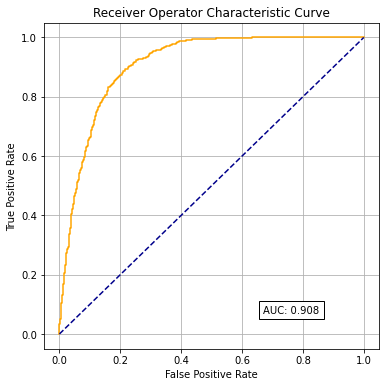

In [9]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.67,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()

## Get model importances

In [10]:
importance = model.feature_importances_

importance = pd.DataFrame(importance, columns=['Importance'], index = list(X_test))

importance

,Importance
hospital_subnet,0.163817
clinical_subnet,0.528795
pathway_subnet,0.307388


## Fit Shap to model predicting use of thrombolysis

In [11]:
# Train explainer on Training set
explainer = shap.TreeExplainer(model, X_train)

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
# Shap values exist for each classification in a Tree; 1=give thrombolysis
shap_values = shap_values_extended.values

In [12]:
# Calculate mean Shapley value for each feature in trainign set
importance['mean_shapley_values'] = np.mean(shap_values, axis=0)

# Calculate mean absolute Shapley value for each feature in test set
# This will give us the average importance of each feature
importance['mean_abs_shapley_values'] = np.mean(
    np.abs(shap_values),axis=0)

In [13]:
importance

,Importance,mean_shapley_values,mean_abs_shapley_values
hospital_subnet,0.163817,0.048505,0.482181
clinical_subnet,0.528795,0.067698,2.508726
pathway_subnet,0.307388,-0.052746,1.327203


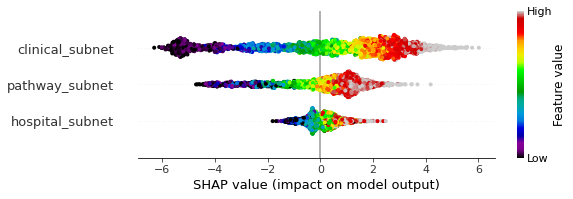

In [14]:
features = list(X_test)

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=12,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/subnet_xgb_beeswarm.png', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

### Example Shap waterfall plots

In [15]:
# Get the location of an example each of low/high probability of giving thrombolysis

location_low_probability = np.where(y_probs == y_probs.min())[0][0]
location_high_probability = np.where(y_probs == y_probs.max())[0][0]

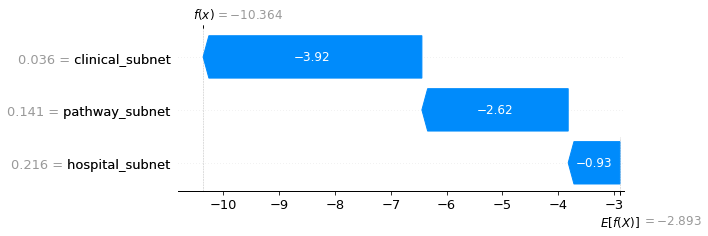

In [16]:
fig = shap.plots.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=12)
plt.savefig('output/subnet_xgb_low_prob_waterfall.png', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

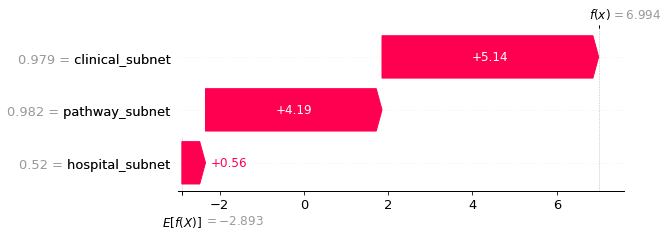

In [17]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=12)
plt.show()

### Histograms of shap values 

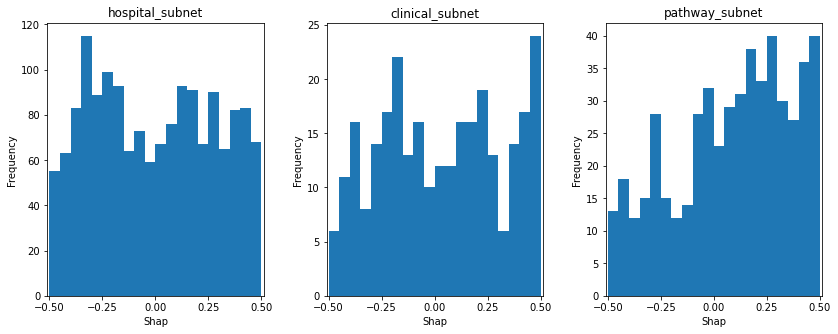

In [18]:
fig = plt.figure(figsize=(12,5))
for i in range(3):
    feature = list(X_test)    
    ax = fig.add_subplot(1,3,i+1)
    ax.hist(shap_values[:,i], bins=np.arange(-0.5, 0.51, 0.05));
    ax.set_title(feature[i])
    ax.set_xlabel('Shap')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-0.51,0.51)
    ax.set_xticks(np.arange(-0.5, 0.51,0.25))
plt.tight_layout(pad=2)
plt.savefig('output/subnet_xgb_histogram.png', dpi=300)
plt.show()
    

## Show relationship between subnet outputs and classification

### Show relationship between clinical subnet output and predicted probability of receiving thrombolysis

In [19]:
# Average probability by subnet bins
bins = np.arange(0, 1.0, 0.1)
indicies = np.digitize(data['clinical_subnet'], bins)
data['clinical_subnet_bin'] = indicies
binned_data = data.groupby(['clinical_subnet_bin']).mean()
data.drop('clinical_subnet_bin', inplace=True, axis=1)

In [20]:
binned_data

,hospital_subnet,clinical_subnet,pathway_subnet,Thrombolysis,predicted_prob
clinical_subnet_bin,,,,,
1,0.425268,0.043889,0.677828,0.000623,0.010953
2,0.430479,0.159234,0.506618,0.008386,0.014679
3,0.430474,0.249735,0.571295,0.030100,0.030687
4,0.415898,0.349169,0.621999,0.058158,0.057837
5,0.436608,0.449362,0.645144,0.107143,0.110153
6,0.429545,0.551970,0.663647,0.161027,0.188194
7,0.428955,0.650145,0.679734,0.272558,0.290411
8,0.437930,0.751507,0.712321,0.413600,0.430813
9,0.433388,0.850111,0.756794,0.603175,0.586085


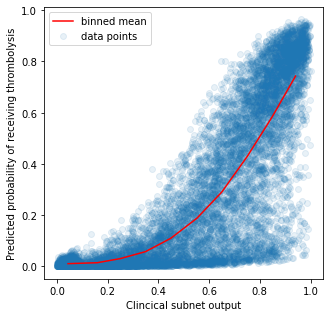

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(data['clinical_subnet'], data['predicted_prob'],alpha=0.1, label='data points')
ax.plot(binned_data['clinical_subnet'], binned_data['predicted_prob'], c='r', label='binned mean')
ax.set_xlabel('Clincical subnet output')
ax.legend()
ax.set_ylabel('Predicted probability of receiving thrombolysis')
plt.show()

Show interaction between clinical and pathway subnet outputs

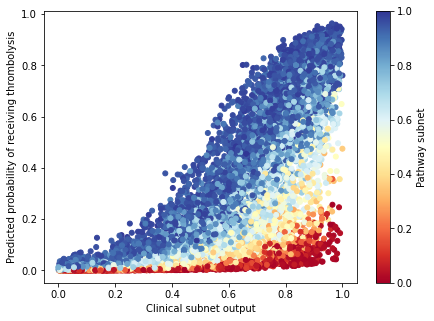

In [22]:
fig = plt.figure(figsize=(7,5))
cm = plt.cm.get_cmap('RdYlBu')
# Plot 1: actual vs subnet
ax1 = fig.add_subplot(111)
im = ax1.scatter(data['clinical_subnet'],
                 data['predicted_prob'],
                 c=data['pathway_subnet'],
                 vmin=0, vmax=1, s=25, cmap=cm, alpha=1,
                 label='data points')
ax1.set_xlabel('Clinical subnet output')
ax1.set_ylabel('Predicted probability of receiving thrombolysis')
plt.colorbar(im, ax=ax1,
             label='Pathway subnet')
plt.savefig('output/clinical_pathway_subnet_scatter.png', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

### Show relationship between pathway subnet output and predicted probability of receiving thrombolysis

In [23]:
# Average probability by subnet bins
bins = np.arange(0, 1.0, 0.1)
indicies = np.digitize(data['pathway_subnet'], bins)
data['pathway_subnet_bin'] = indicies
binned_data = data.groupby(['pathway_subnet_bin']).mean()
data.drop('pathway_subnet_bin', inplace=True, axis=1)

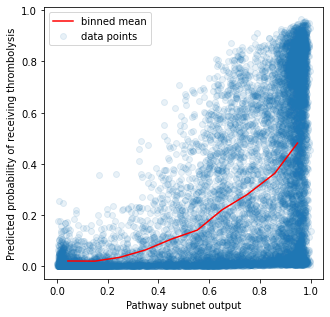

In [24]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(data['pathway_subnet'], data['predicted_prob'],alpha=0.1, label='data points')
ax.plot(binned_data['pathway_subnet'], binned_data['predicted_prob'], c='r', label='binned mean')
ax.set_xlabel('Pathway subnet output')
ax.legend()
ax.set_ylabel('Predicted probability of receiving thrombolysis')
plt.show()

### Show relationship between hospital subnet output and predicted probability of receiving thrombolysis

In [25]:
# Average probability by subnet bins
bins = np.arange(0, 1.0, 0.1)
indicies = np.digitize(data['hospital_subnet'], bins)
data['hospital_subnet_bin'] = indicies
binned_data = data.groupby(['hospital_subnet_bin']).mean()
data.drop('hospital_subnet_bin', inplace=True, axis=1)

In [26]:
binned_data

,hospital_subnet,clinical_subnet,pathway_subnet,Thrombolysis,predicted_prob
hospital_subnet_bin,,,,,
1,0.012142,0.536332,0.641377,0.172524,0.162909
2,0.166154,0.530073,0.692823,0.222714,0.218283
3,0.268615,0.537731,0.705282,0.251627,0.254367
4,0.363597,0.556697,0.720521,0.306174,0.309138
5,0.446399,0.533202,0.663110,0.288116,0.288052
6,0.544581,0.549984,0.697275,0.321624,0.334344
7,0.661176,0.546885,0.704195,0.355169,0.365785
8,0.741509,0.549904,0.673705,0.367961,0.378458
9,0.878767,0.553227,0.723161,0.434263,0.448034


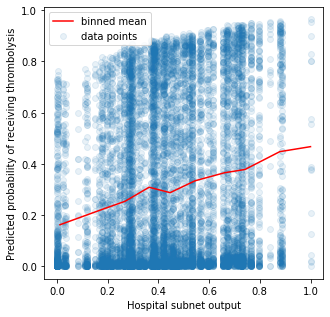

In [27]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(data['hospital_subnet'], data['predicted_prob'],alpha=0.1, label='data points')
ax.plot(binned_data['hospital_subnet'], binned_data['predicted_prob'], c='r', label='binned mean')
ax.set_xlabel('Hospital subnet output')
ax.legend()
ax.set_ylabel('Predicted probability of receiving thrombolysis')
plt.show()

## Fit XGBoost regressor to clinical subnet

In [28]:
clinical_input = pd.read_csv('./predictions/cohort_clinical_input.csv')

In [29]:
X = clinical_input
y = data['clinical_subnet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [30]:
# Define model
model = XGBRegressor()

# Fit model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=36,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
y_pred = model.predict(X_test)

In [32]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
r_squared = r_value**2
print (f'R-squared: {r_squared:0.3f}')

R-squared: 0.995


Text(0.5, 1.0, 'XG-Boost regression of clinical subnet\nR-squared: 0.995')

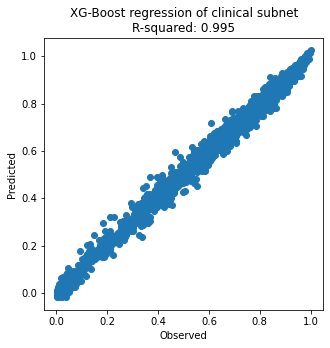

In [33]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title(f'XG-Boost regression of clinical subnet\nR-squared: {r_squared:0.3f}')

In [34]:
importance = model.feature_importances_

importance = pd.DataFrame(importance, columns=['Importance'], index = list(X_test))

importance.sort_values('Importance', ascending=False).head(10)

,Importance
S2StrokeType_Infarction,0.459266
AFAnticoagulent_Yes,0.247427
S2NihssArrival,0.126967
S2RankinBeforeStroke,0.041445
StrokeTIA_Yes,0.011489
BestLanguage,0.011372
Loc,0.010500
AFAnticoagulent_No,0.010354
AtrialFibrillation_Yes,0.008837
AFAnticoagulentDOAC_Yes,0.007345


### Explain prediction of clinical subnet output with Shap

In [35]:
# Train explainer on Training set
explainer = shap.TreeExplainer(model, X_train)

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
# Shap values exist for each classification in a Tree; 1=give thrombolysis
shap_values = shap_values_extended.values

In [36]:
# Calculate mean Shapley value for each feature in trainign set
importance['mean_shapley_values'] = np.mean(shap_values, axis=0)

# Calculate mean absolute Shapley value for each feature in test set
# This will give us the average importance of each feature
importance['mean_abs_shapley_values'] = np.mean(
    np.abs(shap_values),axis=0)

In [37]:
importance.sort_values('mean_abs_shapley_values', ascending=False).head(10)

,Importance,mean_shapley_values,mean_abs_shapley_values
S2StrokeType_Infarction,0.459266,0.018285,0.175898
S2NihssArrival,0.126967,0.008888,0.129465
S2RankinBeforeStroke,0.041445,0.009443,0.051872
AFAnticoagulent_Yes,0.247427,0.011065,0.047570
BestLanguage,0.011372,0.002068,0.033018
StrokeTIA_Yes,0.011489,0.002382,0.016990
S1AgeOnArrival,0.003681,0.001754,0.013962
AFAnticoagulentHeparin_No,0.005841,-0.000497,0.013534
Loc,0.010500,-0.000356,0.010972
AFAnticoagulent_No,0.010354,0.001725,0.010754


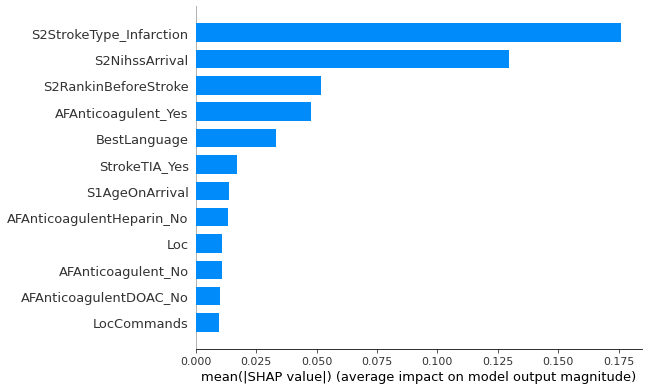

In [38]:
features = list(X_test)

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=12,plot_type='bar',
                  show=False)
plt.show()

plot_type='bar'

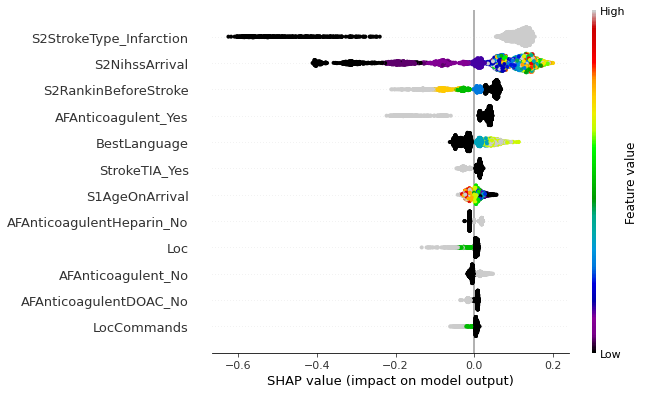

In [39]:
features = list(X_test)

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=12,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/clinical_subnet_regressor.png', dpi=300,bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

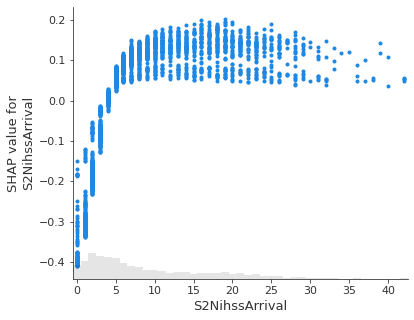

In [40]:
feat = 'S2NihssArrival'
shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)

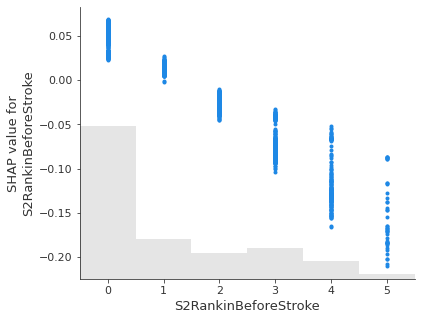

In [41]:
feat = 'S2RankinBeforeStroke'
shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)

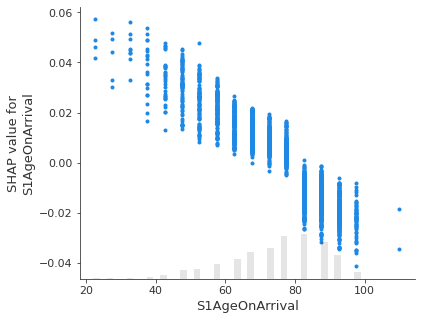

In [42]:
feat = 'S1AgeOnArrival'
shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)

## Fit XG Boost regressor to pathway subnet output

In [43]:
pathway_input = pd.read_csv('./predictions/cohort_pathway_input.csv')

In [44]:
X = pathway_input
y = data['pathway_subnet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [45]:
# Define model
model = XGBRegressor()

# Fit model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=36,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
y_pred = model.predict(X_test)

In [47]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
r_squared = r_value**2
print (f'R-squared: {r_squared:0.3f}')

R-squared: 0.997


Text(0.5, 1.0, 'XG-Boost regression of pathway subnet\nR-squared: 0.997')

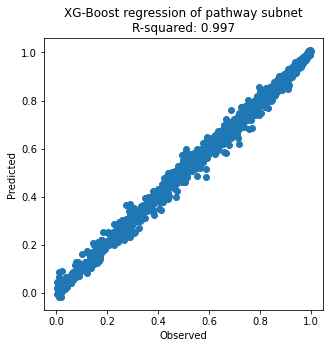

In [48]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title(f'XG-Boost regression of pathway subnet\nR-squared: {r_squared:0.3f}')

In [49]:
importance = model.feature_importances_

importance = pd.DataFrame(importance, columns=['Importance'], index = list(X_test))

importance.sort_values('Importance', ascending=False).head(10)

,Importance
S1OnsetTimeType_Precise,0.406708
S1OnsetDateType_Stroke during sleep,0.327750
S2BrainImagingTime_min,0.180608
S1OnsetToArrival_min,0.016696
S1AdmissionYear_2018,0.015290
S1AdmissionHour_03:00 to 05:59,0.006752
S1AdmissionDay_Saturday,0.006304
S1AdmissionDay_Monday,0.004618
S1AdmissionYear_2017,0.004356
S1AdmissionHour_00:00 to 02:59,0.004127


### Explain prediction of pathway subnet output with Shap

In [50]:
# Train explainer on Training set
explainer = shap.TreeExplainer(model, X_train)

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
# Shap values exist for each classification in a Tree; 1=give thrombolysis
shap_values = shap_values_extended.values

In [51]:
# Calculate mean Shapley value for each feature in trainign set
importance['mean_shapley_values'] = np.mean(shap_values, axis=0)

# Calculate mean absolute Shapley value for each feature in test set
# This will give us the average importance of each feature
importance['mean_abs_shapley_values'] = np.mean(
    np.abs(shap_values),axis=0)

In [52]:
importance.sort_values('mean_abs_shapley_values', ascending=False).head(10)

,Importance,mean_shapley_values,mean_abs_shapley_values
S1OnsetTimeType_Precise,0.406708,0.006814,0.130196
S2BrainImagingTime_min,0.180608,-0.030012,0.124140
S1OnsetToArrival_min,0.016696,-0.004961,0.044289
S1OnsetDateType_Stroke during sleep,0.327750,-0.002877,0.019193
S1AdmissionYear_2018,0.015290,-0.000326,0.011669
S1AdmissionYear_2017,0.004356,0.000412,0.007552
S1AdmissionQuarter_Q1,0.002928,-0.000472,0.005320
S1AdmissionDay_Monday,0.004618,-0.000429,0.005305
S1AdmissionDay_Saturday,0.006304,0.000579,0.005273
S1AdmissionHour_12:00 to 14:59,0.002357,-0.000730,0.004945


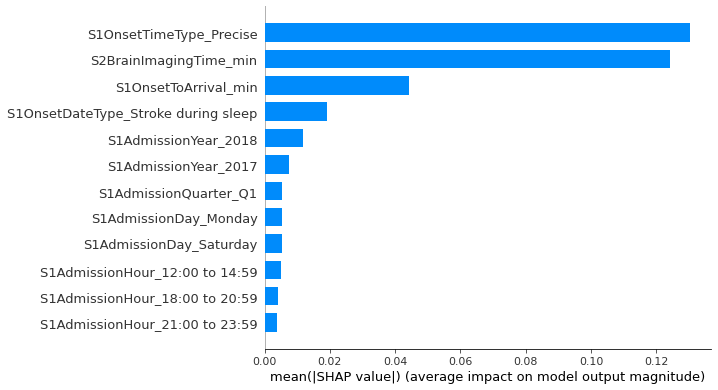

In [53]:
features = list(X_test)

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=12,plot_type='bar',
                  show=False)
plt.show()

plot_type='bar'

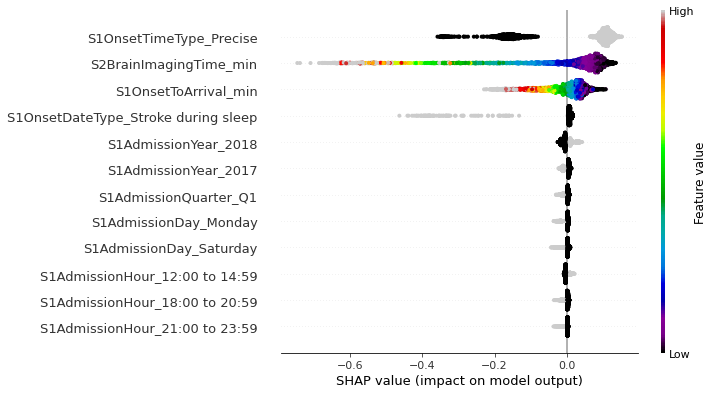

In [54]:
features = list(X_test)

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=12,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/pathway_subnet_regressor.png', dpi=300,bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

(0.0, 450.0)

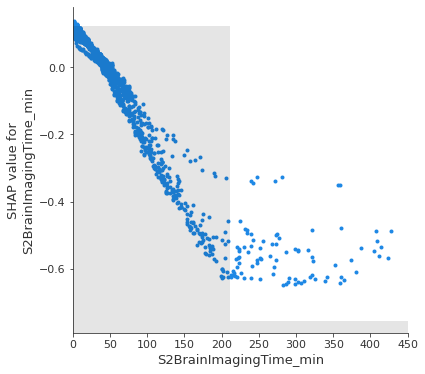

In [55]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_extended[:, 'S2BrainImagingTime_min'], 
                   x_jitter=0, ax=ax, show=False)
ax.set_xlim(0,450)

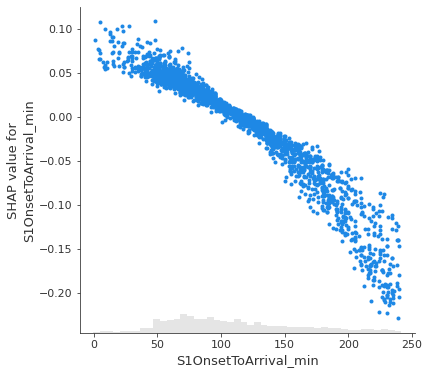

In [56]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_extended[:, 'S1OnsetToArrival_min'], 
                   x_jitter=0, ax=ax, show=False)

## Observations

* An XGBoost model based just on the three embedding subnet outputs from the 1D embedding networks predicts use of thrombolysis with 82.3% accuracy, annd with an ROC AUC of 0.895.

* Both XGBoost *importance* and Shap values had the following order of influence of embedding subnet output: Clinical > Pathway > Hospital.

* An XGBoost regressor predicts clinical subnet output with R-Squared of 0.994.

* The five most influential clincal features, assesed by model *importance*, were:
    * Stroke type
    * AF Anticoagulant
    * Stroke severity (NIHSS)
    * Disability (Rankin) before stroke
    * Previous TIA

* The five most influential clincal features, assesed by Shap values, were:
    * Stroke type
    * Stroke severity (NIHSS)
    * Disability (Rankin) before stroke
    * AF Anticoagulant
    * NIHSS 'best language' score

* An XGBoost regressor predicts clinical subnet output with R-Squared of 0.996.

* The three most influential pathway features, assesed by model *importance*, were:
    * Onset time type (precise vs. estimated)
    * Onset during sleep
    * Time from arrival to scan

* The three most influential pathway features, assesed by model *importance*, were:
    * Time from arrival to scan 
    * Onset time type (precise vs. estimated)
    * Time from onset to arrival